In [67]:
import os
import pickle

from datetime import datetime
from numpy import corrcoef

import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

In [149]:
TROOL_HOME = os.path.expanduser("~") + "/trool"
TROOL_DATA_DIR = TROOL_HOME + "/data"
STRIKE_PRICE_RANGE = 2

In [5]:
date_today = datetime.today().date()

In [6]:
with open(TROOL_DATA_DIR + "/NIFTY/{}/weekly".format(date_today), "rb") as inf:
    nf_weekly = pickle.load(inf)
with open(TROOL_DATA_DIR + "/NIFTY/{}/monthly".format(date_today), "rb") as inf:
    nf_monthly = pickle.load(inf)

In [7]:
def find_index_closest_to_value(value_list, value):
    sorted_value_list = sorted(value_list)
    closest = 0
    for index in range(1, len(value_list)):
        if abs(int(sorted_value_list[index]) - int(value)) < abs(int(sorted_value_list[closest]) - int(value)):
            closest = index
    return closest

In [68]:
def get_strike_price_range(oc):
    close_strike_prices = set()
    for ts in oc.keys():
        tsoc = oc[ts]["oc"]
        strike_price_index = find_index_closest_to_value(list(tsoc.keys()), float(oc[ts]["value"]))
        strike_range = sorted(list(tsoc.keys()))[strike_price_index - STRIKE_PRICE_RANGE:strike_price_index + STRIKE_PRICE_RANGE + 1]
        close_strike_prices.update(strike_range)
    return close_strike_prices

In [99]:
def plot_shared_x_axis(x, y1, y1label, y2, y2label):
    x = [datetime.strptime(ts, "%Y-%m-%d %H:%M:%S") for ts in x]
    y1 = [float(val) for val in y1]
    y2 = [float(val) for val in y2]
    corr_coef = corrcoef(y1, y2)[0][1]
    fig = plt.figure()
#     fig.set_size_inches(20,10)
    ax1 = fig.add_subplot(111)
    ax1.plot(x, y1)
    ax1.set_ylabel(y1label)
    
    ax2 = ax1.twinx()
    ax2.plot(x, y2, 'r-')
    ax2.set_ylabel(y2label, color='r')
    for tl in ax2.get_yticklabels():
        tl.set_color('r')
    plt.xticks(rotation=90)
    plt.title("{} - {}\nCorr: {:.2f}".format(y1label, y2label, corr_coef))
    fig.show()

In [172]:
def plot_strike_price_data(option_type, index_values, strike_price_filter=None, **kwargs):
    fig, ax = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle(option_type, fontsize=35)
    ax[0, 0].set_title("INDEX", fontsize=20)
    ax[0, 0].plot(index_values)
    
    plot_number = 1
    for key in kwargs.keys():
        plot_axis = ax[int(plot_number / 3), plot_number % 3]
        if strike_price_filter:
            strike_prices = strike_price_filter
        else:
            strike_prices = kwargs[key].keys()
        for strike_price in strike_prices:
            values = [float(val.replace(",", "")) for val in kwargs[key][strike_price] if val != '-']
            plot_axis.plot(values)
        plot_axis.set_title(key.upper(), fontsize=20)
        plot_axis.legend(strike_prices, fontsize=15)
        plot_number += 1

In [169]:
def plot_oc_chain_data(oc, strike_price_filter=None):
    strike_price_range = get_strike_price_range(oc)
    index_values, india_vix = [], []
    call_oi, call_change_in_oi, call_volume, call_iv, call_ltp = {}, {}, {}, {}, {}
    put_oi, put_change_in_oi, put_volume, put_iv, put_ltp = {}, {}, {}, {}, {}
    for ts in oc.keys():
        index_values.append(oc[ts]["value"])
        india_vix.append(oc[ts]["india_vix"])
        tsoc = oc[ts]["oc"]
        for strike_price in strike_price_range:
            call_tsoc = tsoc[strike_price]["Call"]
            call_oi[strike_price] = call_oi.get(strike_price, []) + [call_tsoc["OI"]]
            call_change_in_oi[strike_price] = call_change_in_oi.get(strike_price, []) + [call_tsoc["ChangeInOI"]]
            call_volume[strike_price] = call_volume.get(strike_price, []) + [call_tsoc["Volume"]]
            call_iv[strike_price] = call_iv.get(strike_price, []) + [call_tsoc["IV"]]
            call_ltp[strike_price] = call_ltp.get(strike_price, []) + [call_tsoc["LTP"]]
            
            put_tsoc = tsoc[strike_price]["Put"]
            put_oi[strike_price] = put_oi.get(strike_price, []) + [put_tsoc["OI"]]
            put_change_in_oi[strike_price] = put_change_in_oi.get(strike_price, []) + [put_tsoc["ChangeInOI"]]
            put_volume[strike_price] = put_volume.get(strike_price, []) + [put_tsoc["Volume"]]
            put_iv[strike_price] = put_iv.get(strike_price, []) + [put_tsoc["IV"]]
            put_ltp[strike_price] = put_ltp.get(strike_price, []) + [put_tsoc["LTP"]]
    index_len = len(index_values)
    assert len(india_vix) == index_len
    for var in [call_oi, call_change_in_oi, call_volume, call_iv, put_oi, put_change_in_oi, put_volume, put_iv]:
        for strike_price in var.keys():
            assert len(var[strike_price]) == index_len
            
    index_values = [float(ind_val) for ind_val in index_values]
    timestampts =  list(oc.keys())
    plot_shared_x_axis(timestampts, index_values, "index", india_vix, "india_vix")
    plot_strike_price_data("Call Options", index_values, strike_price_filter=strike_price_filter, oi=call_oi, change_in_oi=call_change_in_oi,
                           volume=call_volume, iv=call_iv, ltp=call_ltp)


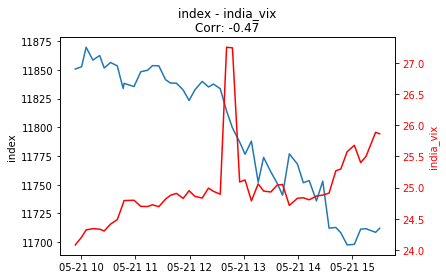

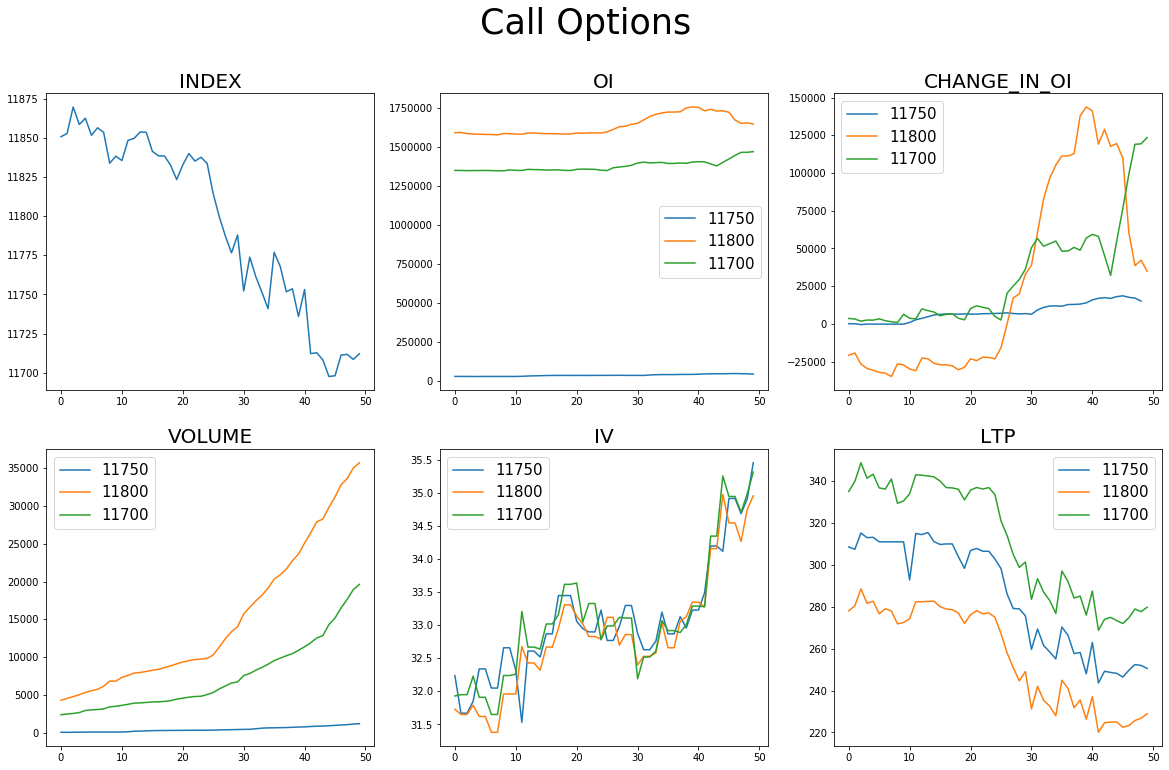

In [173]:
plot_oc_chain_data(nf_monthly, [11750,11800, 11700])

### Weekly Analysis

In [ ]:
for date

### Monthly Analysis